In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import *

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

## Data

### Campbell HR and Local Age

Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}
Resulting data will be an inner join of the two


,age
snid,
762,2.021842
762,2.833909
762,2.580368
762,2.397617
762,2.629097


,hr,hr_err
snid,,
762,0.15,0.08
1032,-0.15,0.12
1371,-0.14,0.06
1794,0.27,0.08
2372,-0.12,0.07


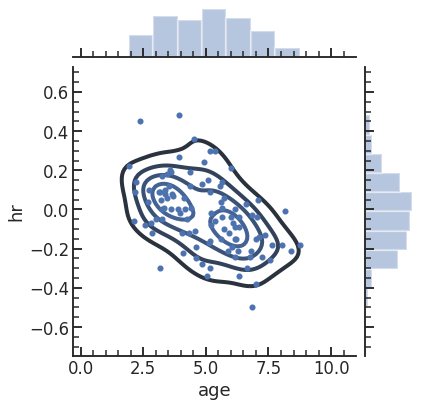

In [2]:
# load_age_sample_from_mcmc_chains('campbell', mode="write")
age_df = load_age_sample_from_mcmc_chains('campbell', mode="read")
age_df = age_df.set_index("snid").sort_index()

hr_df = load_hr("campbell")
hr_df = hr_df
hr_df.columns = hr_df.columns.str.lower()
hr_df = (hr_df.rename(columns={
    "sdss": "snid",
    "e_hr": "hr_err"
})
         .set_index("snid")
         .sort_index()[["hr", "hr_err"]])

in_age_not_hr = set(age_df.index) - set(hr_df.index)
in_hr_not_age = set(hr_df.index) - set(age_df.index)
print("Missing from R19 Table 1 of SNID:", in_age_not_hr)
print("Missing from Campbell MCMC chains of SNID:", in_hr_not_age)

print("Resulting data will be an inner join of the two")
age_df = age_df.drop(index=in_age_not_hr)
hr_df = hr_df.drop(index=in_hr_not_age)
snids = age_df.index.unique().tolist()

display(age_df.head())
display(hr_df.head())

# Joint plot of Age and HR row means
sns.jointplot( age_df.groupby('snid').mean()['age'], hr_df['hr'], s=15).plot_joint(sns.kdeplot, zorder=0, n_levels=4);

## Correlation Analysis

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between ```Age_all``` and ```HR_all```.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a correlation, but it is not strong enough to deny dark energy
    4. there is a strong correlation, but slope is not large enough to deny dark energy
    5. there is a strong correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

### Statistical Simulation - Sampling Age and Hubble Residual
To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given it respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [3]:
def simulate(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_sample = RNG.choice(age_df.loc[snid, "age"], size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

def get_simulation():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_simulation.csv")

# simulate(age_df, hr_df)
result_df = get_simulation()

### Simulation Results

In [4]:
def get_slope_parameter(x, y):
    """Return the mean and variance of the OLS slope parameter"""
    corr = stats.pearsonr(x, y)[0]
    slope = corr * (np.std(y) / np.std(x))
    
    sigma2 = (np.var(y)**2 + np.var(x)**2)
    slope_var = sigma2 / np.sum((x-np.mean(x))**2)
    
    return slope, slope_var

x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

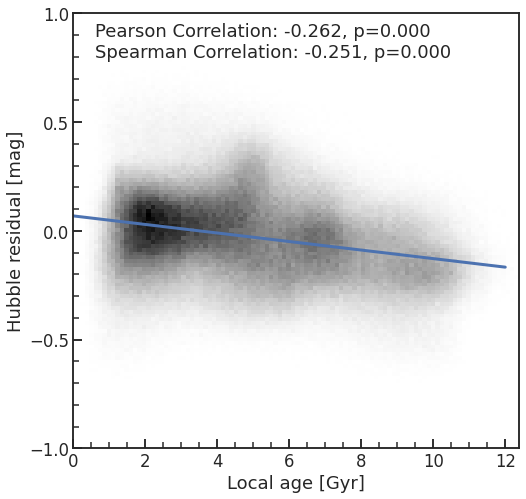

In [5]:
plt.figure(figsize=(8,8))
plt.hist2d(x, y, bins=100, cmap='gray_r')

xrange = np.linspace(0, 12, 100)
plt.plot(xrange, slope*xrange + intercept, lw=3)

plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.xlabel("Local age [Gyr]")
plt.ylabel("Hubble residual [mag]")
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(-1, 1.5, 0.5));

## Incorrect Correlation Analysis

Attempting to incorrectly do correlation analysis that L20 did which changes the previous correlation analysis by the assumption of the Age distribution:

* 10000 samples without replacement of Age assumed to be <span style="color: red">Gaussian parameters from the MCMC-derived posterior mean and SD</span>.

In [6]:
def simulate_incorrectly(age_df, hr_df, repetitions=1000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_dist = stats.norm(loc=age_df.loc[snid, 'age'].mean(), scale=age_df.loc[snid, 'age'].std()) 
        snid_age_dist.random_state = RNG
        snid_age_sample = snid_age_dist.rvs(size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"campbell_hr_age_incorrect_simulation.csv")

def get_incorrect_simulation():
    return pd.read_csv(RESULTSPATH/"campbell_hr_age_incorrect_simulation.csv")

# simulate_incorrectly(age_df, hr_df)
incorrect_result_df = get_incorrect_simulation()

([<matplotlib.axis.YTick at 0x7fe37ea898b0>,
 <a list of 5 Text major ticklabel objects>)

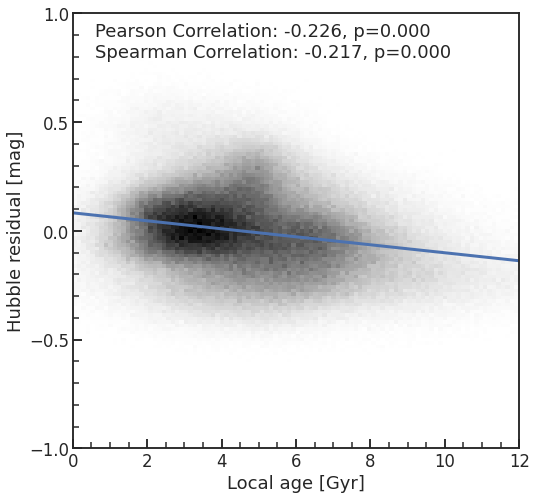

In [7]:
x, y = incorrect_result_df['age'], incorrect_result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope = corr * (np.std(y) / np.std(x))
intercept = np.mean(y) - slope*np.mean(x)

plt.figure(figsize=(8,8))
cut = (x > 0) & (x < 12)
plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')

xrange = np.linspace(0, 12, 100)
plt.plot(xrange, slope*xrange + intercept, lw=3)

plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.xlabel("Local age [Gyr]")
plt.ylabel("Hubble residual [mag]")
plt.xticks(np.arange(0, 14, 2))
plt.yticks(np.arange(-1, 1.5, 0.5))

In [8]:
# plt.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
# plt.errorbar(
#     age_df.groupby('snid').mean()["age"], 
#     hr_df.groupby('snid').mean()["hr"], 
#     xerr=age_df.groupby('snid').std()["age"], 
#     yerr=hr_df["hr"].groupby('snid').apply(lambda s: np.sqrt(np.sum(s**2))), 
#     fmt='.', lw=1)

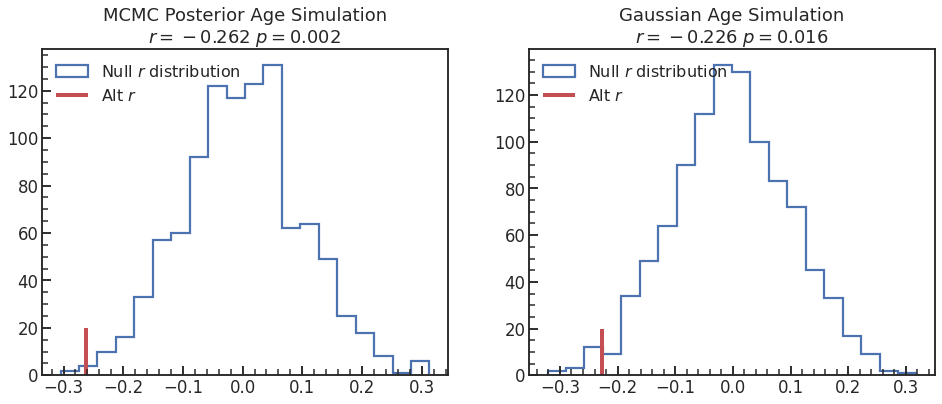

In [9]:
def correlation_test(x, y, corr_func=stats.pearsonr, sample_size=100, repetition=1000):
    """Test the significance of the correlation with null hypothesis of zero correlation"""
    corr = corr_func(x, y)[0] # We will ignore 2nd arg which is the p-value
    
    corr_samples = []
    for i in range(repetition):
        x_sample = np.random.choice(x, size=sample_size)
        y_sample = np.random.choice(y, size=sample_size)
        corr_sample = corr_func(x_sample, y_sample)[0]
        corr_samples.append(corr_sample)
    
    pvalue = np.mean(corr_samples <= corr)
    return corr, pvalue, corr_samples

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax = axes[0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')

ax = axes[1]
_corr, _pvalue, _corr_samples = correlation_test(incorrect_result_df['age'], incorrect_result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ distribution")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation\n$r={_corr:.3f}$ $p={_pvalue:.3f}$")
ax.legend(loc='upper left')


## Summary

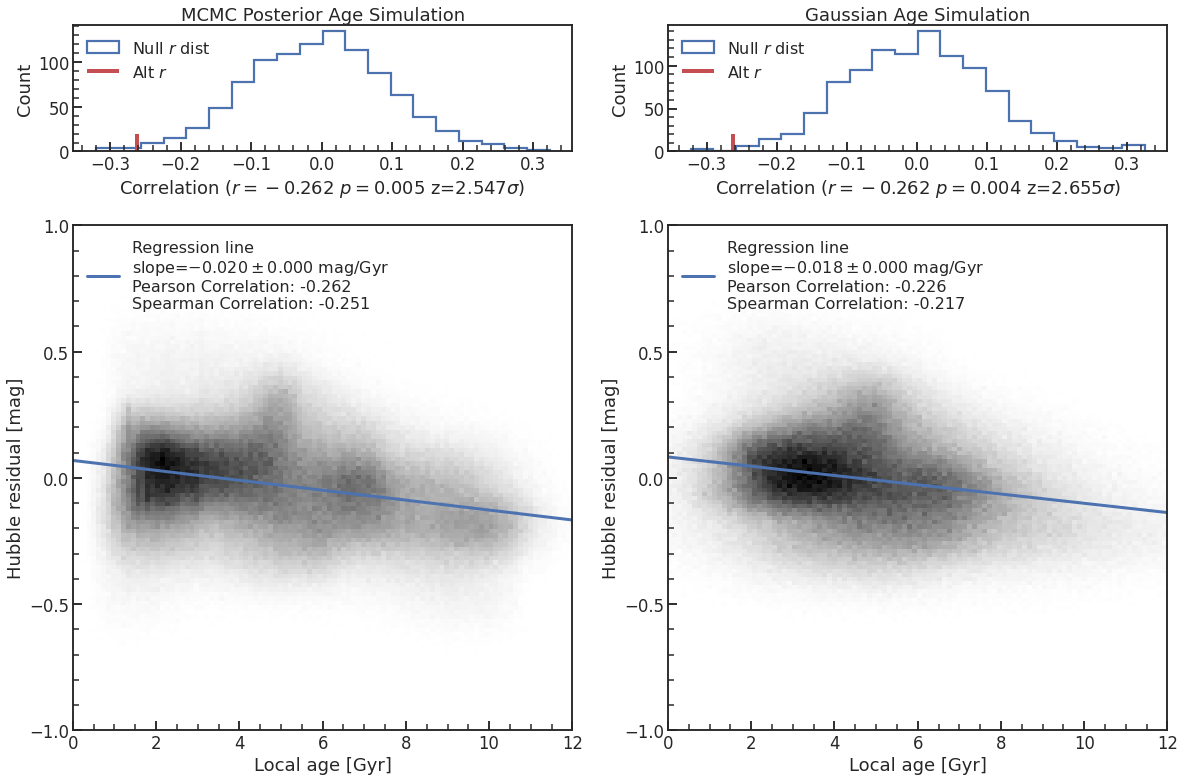

In [10]:
def get_zscore(dist, value):
    mean = np.mean(dist)
    std = np.std(dist)
    
    return np.abs(mean - value) / std

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21*.80, 14*.80), gridspec_kw={'height_ratios': [1, 4]})

# Correct Simulation
x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax = axes[1, 0]
cut = (x > 0) & (x < 12)
ax.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
xrange = np.linspace(0, 12, 100)
ax.plot(xrange, slope*xrange + intercept, lw=3, label=f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}")

ax.set_xlabel("Local age [Gyr]")
ax.set_ylabel("Hubble residual [mag]")
ax.set_xticks(np.arange(0, 14, 2))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.legend(loc='upper left')

ax = axes[0, 0]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ dist")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"MCMC Posterior Age Simulation", pad=5)
ax.set_xlabel(f"Correlation ($r={_corr:.3f}$ $p={_pvalue:.3f}$ z={get_zscore(_corr_samples, _corr):.3f}$\sigma$)")
ax.set_ylabel("Count")
ax.legend(loc='upper left')

# Incorrect Simulation
x, y = incorrect_result_df['age'], incorrect_result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax = axes[1, 1]
cut = (x > 0) & (x < 12)
ax.hist2d(x[cut], y[cut], bins=100, cmap='gray_r')
xrange = np.linspace(0, 12, 100)
ax.plot(xrange, slope*xrange + intercept, lw=3, label=f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}")

ax.set_xlabel("Local age [Gyr]")
ax.set_ylabel("Hubble residual [mag]")
ax.set_xticks(np.arange(0, 14, 2))
ax.set_yticks(np.arange(-1, 1.5, 0.5))
ax.legend(loc='upper left')

ax = axes[0, 1]
_corr, _pvalue, _corr_samples = correlation_test(result_df['age'], result_df['hr'])
ax.hist(_corr_samples, bins=20, histtype='step', label="Null $r$ dist")
ax.vlines(_corr, 0, 20, colors='r', label="Alt $r$")
ax.set_title(f"Gaussian Age Simulation", pad=5)
ax.set_xlabel(f"Correlation ($r={_corr:.3f}$ $p={_pvalue:.3f}$ z={get_zscore(_corr_samples, _corr):.3f}$\sigma$)")
ax.set_ylabel("Count")
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(FIGURESPATH/"campbell_correlation_summary.pdf")

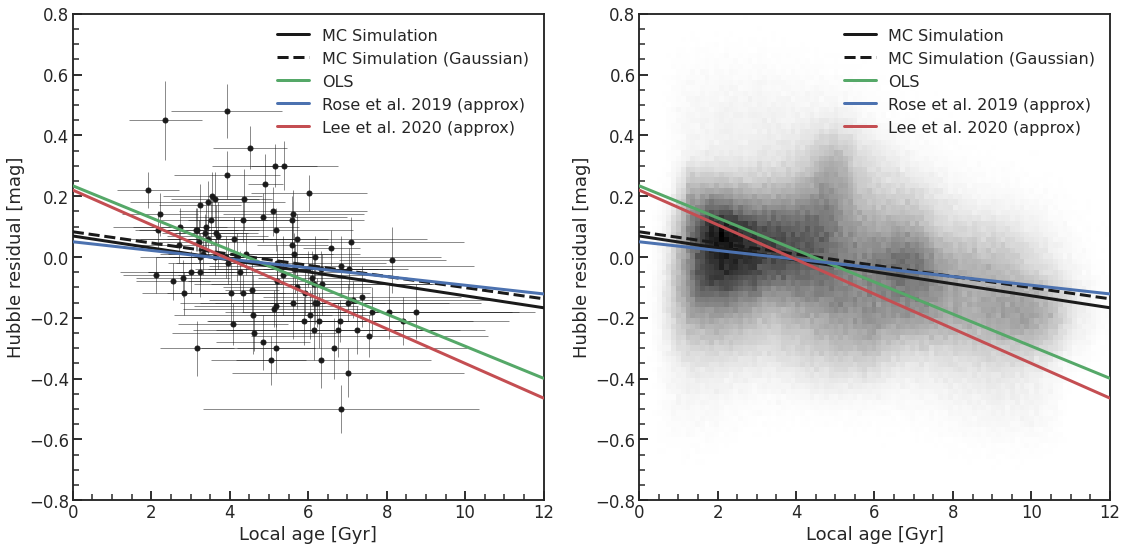

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
ax1, ax2 = axes

summary_date = {
    "K20": None,
    "R19": None,
    "L20": None
}

x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

ax2.hist2d(x, y, bins=100, cmap='gray_r')

ax1.errorbar(age_df["age"].groupby('snid').mean(), hr_df["hr"], xerr=age_df["age"].groupby('snid').std(), yerr=hr_df['hr_err'], fmt='ko', lw=0.5, ms=5)
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='k', lw=3, label=f"MC Simulation", zorder=100)
ax2.plot(xrange, slope*xrange + intercept, c='k', lw=3, label=f"MC Simulation", zorder=100)
# f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}"

# Incorrect Simulation
x, y = incorrect_result_df['age'], incorrect_result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)

xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='k', linestyle='dashed', lw=3, label=f"MC Simulation (Gaussian)", zorder=100)
ax2.plot(xrange, slope*xrange + intercept, c='k', linestyle='dashed', lw=3, label=f"MC Simulation (Gaussian)", zorder=100)
# f"Regression line\nslope=${slope:.3f} \pm {slope_var:.3f}$ mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rcorr:.3f}"


# OLS (no error)
x, y = age_df['age'].groupby('snid').mean(), hr_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope, slope_var = get_slope_parameter(x, y)
intercept = np.mean(y) - slope*np.mean(x)
ax1.plot(xrange, slope*xrange + intercept, c='g', lw=3, label=f"OLS", zorder=100)
ax2.plot(xrange, slope*xrange + intercept, c='g', lw=3, label=f"OLS", zorder=100)

# R19 Regression
slope = -0.1/7
intercept = 0.05
ax1.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019 (approx)", zorder=100)
ax2.plot(xrange, slope*xrange + intercept, lw=3, label=f"Rose et al. 2019 (approx)", zorder=100)

# L20 Regression
slope = -0.057
intercept = 0.22
xrange = np.linspace(0, 12, 100)
ax1.plot(xrange, slope*xrange + intercept, c='r', lw=3, label=f"Lee et al. 2020 (approx)", zorder=100)
ax2.plot(xrange, slope*xrange + intercept, c='r', lw=3, label=f"Lee et al. 2020 (approx)", zorder=100)

ax1.set_xlabel("Local age [Gyr]")
ax1.set_ylabel("Hubble residual [mag]")
ax1.set_xlim(0, 12)
ax2.set_ylim(-0.8, 0.8)
ax1.set_xticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(-0.8, 1, 0.2))
ax1.legend(loc='upper right')

ax2.set_xlabel("Local age [Gyr]")
ax2.set_ylabel("Hubble residual [mag]")
ax2.set_xlim(0, 12)
ax2.set_ylim(-0.8, 0.8)
ax2.set_xticks(np.arange(0, 14, 2))
ax2.set_yticks(np.arange(-0.8, 1, 0.2))
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(FIGURESPATH/"campbell_correlation_summary.pdf")